# Bibliography

Author : Dr. Sreenivas <br>

Youtube : [https://youtu.be/6S2v7G-OupA?si=-25V7djYiafSRdTP] <br>
Github : [https://github.com/bnsreenu/python_for_microscopists/blob/master/180_LSTM_encoder_decoder_anomaly_GE.py] <br>
Lecture Number : 180

# **Learning**

# **Libraries Required**

In [1]:
from keras.models import Model
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM, Input, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

2025-09-22 10:51:16.962743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 10:51:16.988735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 10:51:17.521083: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data

In [14]:
dataframe = pd.read_csv('../data/lstmEnDeAnomaly2025-03.csv')
df[['Date','Close']] = dataframe[['open_time','close']]
df['Date'] = pd.to_datetime(df['Date'], unit="ms")

/tmp/ipykernel_261862/2148547515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Date','Close']] = dataframe[['open_time','close']]
/tmp/ipykernel_261862/2148547515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Date','Close']] = dataframe[['open_time','close']]
/tmp/ipykernel_261862/2148547515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

<Axes: xlabel='open_time', ylabel='close'>

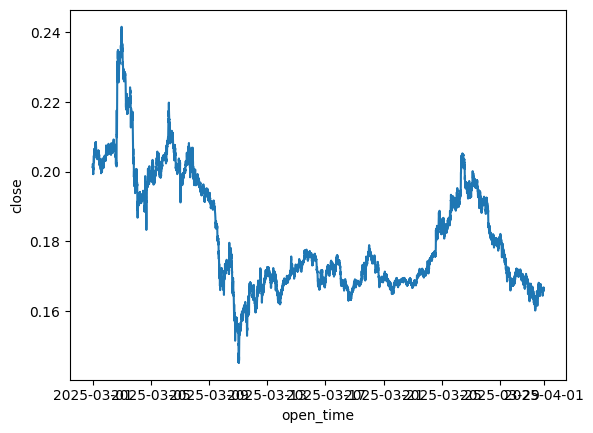

In [15]:
sns.lineplot(x=df['open_time'], y=df['close'])

In [21]:
print(f"Start date is: {df['Date'].min()}")
print(f"End date is: {df['Date'].max()}")

Start date is: 2025-03-01 00:00:00
End date is: 2025-03-31 23:57:00


In [22]:
train, test = df.loc[df['Date'] <= '2025-03-25'], df.loc[df['Date'] > '2025-03-24']

In [25]:
print(f"Length of train: {len(train)}")
print(f"Length of test: {len(test)}")

Length of train: 11521
Length of test: 3839


In [29]:
# Normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/tmp/ipykernel_261862/1105533457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
/tmp/ipykernel_261862/1105533457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [30]:
train

,Date,Close
0,2025-03-01 00:00:00,1.096863
1,2025-03-01 00:03:00,1.091801
2,2025-03-01 00:06:00,1.097988
3,2025-03-01 00:09:00,1.109236
4,2025-03-01 00:12:00,1.146918
...,...,...
11516,2025-03-24 23:48:00,0.051902
11517,2025-03-24 23:51:00,0.052464
11518,2025-03-24 23:54:00,0.062025
11519,2025-03-24 23:57:00,0.069899


## **Preparing data for the model**

$x$ & $y$ in a timeseries anomaly detection is different than what we have in usual prediction of images

In [31]:
seq_size = 30

In [34]:
train['Close'].iloc[1:(1+seq_size)].values

array([1.09180144, 1.09798798, 1.10923622, 1.14691782, 1.15591642,
       1.12048446, 1.14185612, 1.12160928, 1.1086738 , 1.09798798,
       1.07886597, 1.05861913, 1.03049853, 1.03162335, 1.05355742,
       1.02262476, 0.99056727, 0.99225451, 0.98888004, 1.01812546,
       1.02656164, 1.00912687, 1.05074536, 1.05018295, 1.0805532 ,
       1.08392767, 1.07492908, 1.06480566, 1.07042978, 1.07549149])

In [35]:
def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

In [36]:
trainX, trainY = to_sequence(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequence(test[['Close']], test['Close'], seq_size)

In [40]:
print(f"Training data shape: {trainX.shape}")
print(f"Training Label shape: {trainY.shape}")
print(f"Testing data shape: {testX.shape}")
print(f"Testing Label shape: {testY.shape}")

Training data shape: (11491, 30, 1)
Training Label shape: (11491,)
Testing data shape: (3809, 30, 1)
Testing Label shape: (3809,)


# **Model Definition**

In [42]:
trainX.shape[1], trainX.shape[2]

(30, 1)

In [87]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

/home/sebdui/learnin4romDrSreeni/anomalyDetection/.learninAnomalyDetection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,481 (1017.50 KB)

 Trainable params: 260,481 (1017.50 KB)

 Non-trainable params: 0 (0.00 B)

## **Model Training & Evalution**

In [88]:
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.8431 - val_loss: 0.2523
Epoch 2/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8382 - val_loss: 0.2555
Epoch 3/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8375 - val_loss: 0.2525
Epoch 4/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8372 - val_loss: 0.2518
Epoch 5/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8368 - val_loss: 0.2578
Epoch 6/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8366 - val_loss: 0.2563
Epoch 7/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8367 - val_loss: 0.2512
Epoch 8/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8368 - val_loss: 0.2445
Epoch 9/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8369 - val_loss: 0.2597
Epoch 10/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8368 - val_loss: 0.2539
Epoch 11/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8367 - val_loss: 0.2622
Epoch 12/30
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/ste

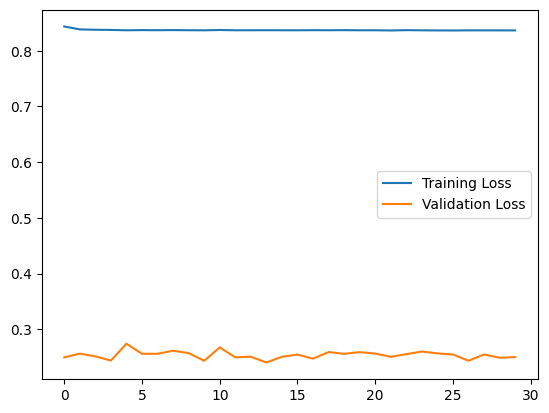

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(array([2188., 1868., 1856.,  510.,  374.,  268.,  159.,  339.,  390.,
         279.,  224.,  522.,  418.,  481.,  564.,  325.,  106.,   47.,
          28.,   81.,   36.,  112.,   36.,   10.,   18.,   93.,   48.,
          42.,   31.,   38.]),
 array([0.01223035, 0.13177812, 0.25132589, 0.37087366, 0.49042143,
        0.6099692 , 0.72951697, 0.84906474, 0.96861251, 1.08816028,
        1.20770805, 1.32725582, 1.44680359, 1.56635136, 1.68589913,
        1.8054469 , 1.92499467, 2.04454244, 2.16409021, 2.28363798,
        2.40318575, 2.52273352, 2.64228129, 2.76182906, 2.88137683,
        3.0009246 , 3.12047237, 3.24002014, 3.35956791, 3.47911568,
        3.59866345]),
 <BarContainer object of 30 artists>)

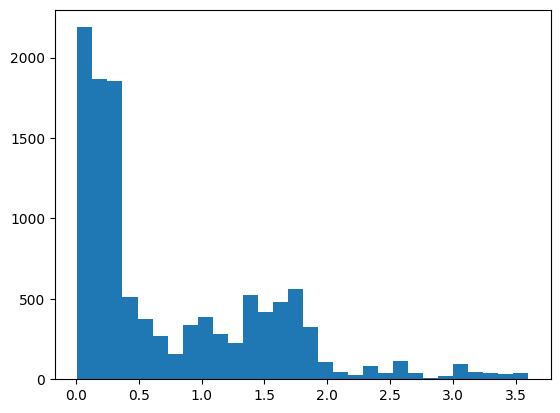

In [57]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

In [77]:
max_trainMAE = 1.75

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(array([141., 334., 257., 199., 230., 239., 353., 159., 201., 169., 125.,
        103.,  49.,  15.,  16., 132., 229., 158.,  65., 143.,  73., 167.,
         61.,  49.,  21.,   7.,  12.,  23.,  35.,  44.]),
 array([0.03521069, 0.09182273, 0.14843476, 0.20504679, 0.26165883,
        0.31827086, 0.3748829 , 0.43149493, 0.48810696, 0.544719  ,
        0.60133103, 0.65794306, 0.7145551 , 0.77116713, 0.82777917,
        0.8843912 , 0.94100323, 0.99761527, 1.0542273 , 1.11083933,
        1.16745137, 1.2240634 , 1.28067543, 1.33728747, 1.3938995 ,
        1.45051154, 1.50712357, 1.5637356 , 1.62034764, 1.67695967,
        1.7335717 ]),
 <BarContainer object of 30 artists>)

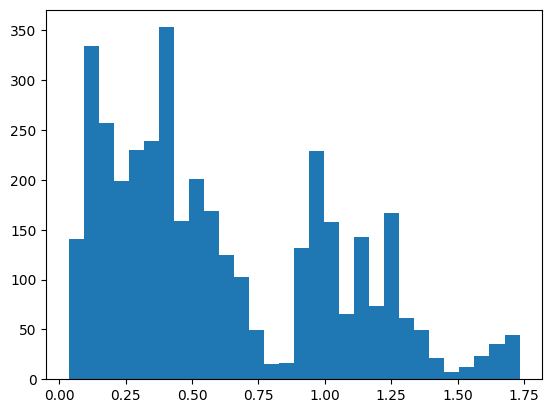

In [78]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [79]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

<Axes: xlabel='Date', ylabel='testMAE'>

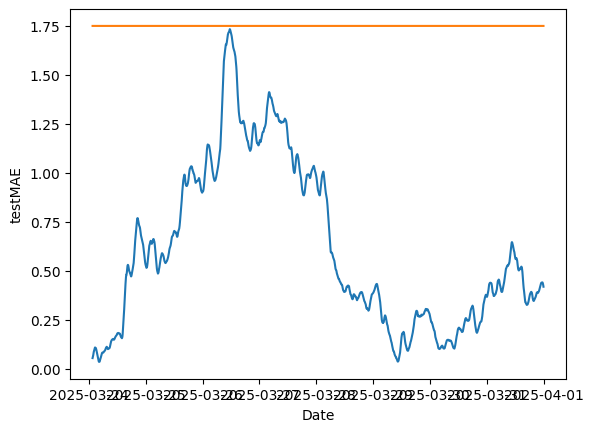

In [80]:
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [81]:
anomaly_df

,Date,Close,testMAE,max_trainMAE,anomaly
11071,2025-03-24 01:33:00,-0.596560,0.054764,1.75,False
11072,2025-03-24 01:36:00,-0.603309,0.057183,1.75,False
11073,2025-03-24 01:39:00,-0.589248,0.059696,1.75,False
11074,2025-03-24 01:42:00,-0.600496,0.061981,1.75,False
11075,2025-03-24 01:45:00,-0.586999,0.064270,1.75,False
...,...,...,...,...,...
14875,2025-03-31 23:45:00,-0.882827,0.432778,1.75,False
14876,2025-03-31 23:48:00,-0.868767,0.429871,1.75,False
14877,2025-03-31 23:51:00,-0.856956,0.426565,1.75,False
14878,2025-03-31 23:54:00,-0.838959,0.423075,1.75,False


In [82]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True ]

In [83]:
anomalies

,Date,Close,testMAE,max_trainMAE,anomaly


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

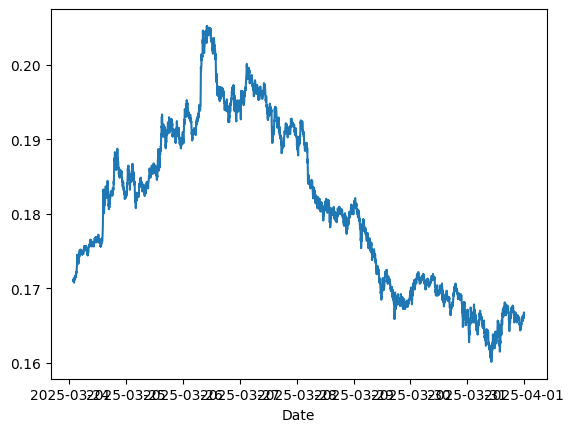

In [84]:
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten())
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), color='r')